In [1]:
import random, math, copy
import matplotlib.pyplot as plt
import sys

In [2]:
from numpy.random import rand
from numpy.random import choice
from numpy import asarray
from numpy import clip
import numpy as np
from numpy import argmax
from numpy import around

In [3]:
def GrieFunc(data): #Objective function
    s1 = 0.
    s2 = 1.
    for k, x in enumerate(data):
        s1 = s1 + x ** 2
        s2 = s2 * math.cos(x/math.sqrt(k+1))
    y = (1./4000.) * s1-s2 + 1
    return 1./(1. + y)

In [4]:
def Sphere(x):
    ss=sum(np.power(x, 2))
    return 1./(1.+ss)

In [5]:
def RastFunc(data):
    """
    Rastrigin function
    """
    s = 10 * 25
    for i in data:
        s = s + i ** 2 - 10 * math.cos(2 * math.pi * i)
    return 1./(1.+s)

In [6]:
class ABC_DE_WOAIndividual:
    def __init__(self, bound):
        self.score = 0.
        self.invalidCount = 0 #Invalid times (the cumulative number of times the score is not updated)
        self.chrom = [random.uniform(a,b) for a,b in zip(bound[0,:],bound[1,:])] #random initialization
        self.calculateFitness()        

    def calculateFitness(self):
        self.score = GrieFunc(self.chrom)
        #self.score = Sphere(self.chrom)
        #self.score = RastFunc(self.chrom)

In [7]:
# define mutation operation
def mutation(x, F):
    return x[0] + F * (x[1] - x[2])

In [8]:
# define boundary check operation
def check_bounds(mutated, bounds):
    mutated_bound = [clip(mutated[i], bounds[0,i], bounds[1,i]) for i in range(len(bounds[0]))]
    return mutated_bound

In [9]:
def crossover(mutated, target, dims, cr):
    # generate a uniform random value for every dimension
    p = rand(dims)
    # generate trial vector by binomial crossover
    trial = [mutated[i] if p[i] < cr else target[i] for i in range(dims)]
    return trial


In [16]:
class ABC_DE_WOA:
    def __init__(self, foodCount, onlookerCount, bound, maxIterCount=1000, maxInvalidCount=200):
        self.foodCount = foodCount                 
        self.onlookerCount = onlookerCount           
        self.bound = bound
        self.F = 0.5  # define scale factor for mutation
        self.cr=0.7  # define crossover rate for recombination
        self.maxIterCount = maxIterCount           
        self.maxInvalidCount = maxInvalidCount    
        self.foodList = [ABC_DE_WOAIndividual(self.bound) for k in range(self.foodCount)]
        self.foodScore = [d.score for d in self.foodList] 
        self.bestFood = copy.copy(self.foodList[np.argmax(self.foodScore)])
        self.rnd = random.Random(0)

        

    def updateFood(self, i):         
        vj = copy.deepcopy(self.foodList[i]) 
        candidates = [candidate for candidate in range(self.foodCount) if candidate != i]        
        ia,ib,ic=tuple(choice(candidates,3,replace=False))
        a=np.asarray(self.foodList[ia].chrom)
        b=np.asarray(self.foodList[ib].chrom)
        c=np.asarray(self.foodList[ic].chrom)

        mutated = mutation([a, b, c], self.F)
        mutated = check_bounds(mutated, self.bound)
        trial = crossover(mutated, self.foodList[i].chrom, len(self.bound[0]), self.cr)
        vj.chrom=trial
        vj.calculateFitness()
        
        
        if vj.score > self.foodList[i].score:           
            self.foodList[i] = vj
            if vj.score > self.foodScore[i]:            
                self.foodScore[i] = vj.score
                if vj.score > self.bestFood.score:     
                    self.bestFood = copy.copy(vj)
            self.foodList[i].invalidCount = 0
        else:
            self.foodList[i].invalidCount += 1
            
            
    def employedBeePhase(self):
        for i in range(0, self.foodCount):              
            self.updateFood(i)            
    
    def woa(self,i,n,a,a2):
        A = 2 * a * self.rnd.random() - a
        C = 2 * self.rnd.random()
        b = 1
        l = (a2-1)*self.rnd.random()+1
        p = self.rnd.random()
        dim=len(self.bound[0])
        D = [0.0 for i in range(dim)]
        D1 = [0.0 for i in range(dim)]
        Xnew = [0.0 for i in range(dim)]
        Xrand = [0.0 for i in range(dim)]
        if p < 0.5:
            if abs(A) > 1:
                for j in range(dim):
                    D[j] = abs(C * self.bestFood.chrom[j] - self.foodList[i].chrom[j])
                    Xnew[j] = self.bestFood.chrom[j] - A * D[j]
            else:
                p = random.randint(0, n - 1)
                while (p == i):
                    p = random.randint(0, n - 1)
                Xrand = self.foodList[p].chrom

                for j in range(dim):
                    D[j] = abs(C * Xrand[j] - self.foodList[i].chrom[j])
                    Xnew[j] = Xrand[j] - A * D[j]
        else:
            for j in range(dim):
                D1[j] = abs(self.bestFood.chrom[j] - self.foodList[i].chrom[j])
                Xnew[j] = D1[j] * math.exp(b * l) * math.cos(2 * math.pi * l) + self.bestFood.chrom[j]
        
        vi = copy.deepcopy(self.foodList[i])
        vi.chrom=Xnew
        for j in range(dim):
            vi.chrom[j] = max(vi.chrom[j], self.bound[0][0])
            def mini(x,y):
                if(x<y):
                    return x
                else:
                    return y
            vi.chrom[j] = mini(vi.chrom[j], self.bound[1][0])
        vi.calculateFitness()
        if vi.score > self.foodList[i].score:           
            self.foodList[i] = vi
            if vi.score > self.foodScore[i]:            
                self.foodScore[i] = vi.score
                if vi.score > self.bestFood.score:     
                    self.bestFood = copy.copy(vi)


            
            
    def onlookerBeePhase(self,Iter):
        a = 2 * (1 - Iter / self.maxIterCount)
        a2=-1+Iter*((-1)/self.maxIterCount)
        
        maxScore = np.max(self.foodScore)        
        accuFitness = [(0.9*d/maxScore+0.1, k) for k,d in enumerate(self.foodScore)] 
        for k in range(0, self.onlookerCount):
            arr2=[d[1] for d in accuFitness if d[0] >= random.random()]
            arr1=[d[1] for d in accuFitness if d[0] < random.random()]
            if(len(arr1)>0):
                j = random.choice(arr1)
                self.updateFood(j)
            if(len(arr2)>0):
                l=random.choice(arr2)
                self.woa(k,self.foodCount,a,a2)
                
                        
            

    def scoutBeePhase(self):
        for i in range(0, self.foodCount):
            if self.foodList[i].invalidCount > self.maxInvalidCount:                   
                self.foodList[i] = ABC_DE_WOAIndividual(self.bound)
                self.foodScore[i] = max(self.foodScore[i], self.foodList[i].score)

    def solve(self):
        trace = []
        trace.append((self.bestFood.score, np.mean(self.foodScore)))
        
        
        for k in range(self.maxIterCount):
            self.employedBeePhase()
            self.onlookerBeePhase(k)
            self.scoutBeePhase()
            trace.append((self.bestFood.score, np.mean(self.foodScore)))
            tt=self.bestFood.score
            tt=(1-tt)/tt
            print("\r['At iteration '"+ str(k)+ "' the best fitness is '"+ str(tt)+"']")
        self.printResult(np.array(trace))

    def printResult(self, trace):
        y = np.arange(0, trace.shape[0])
        plt.plot(y, [(1-d)/d for d in trace[:, 0]], 'r', label='optimal value')
        plt.xlabel("Iteration")
        plt.ylabel("function value")
        plt.title("ABC + DE + Whale algorithm for function optimization")
        plt.legend()
        plt.show()

['At iteration '0' the best fitness is '3.5545618044210148']
['At iteration '1' the best fitness is '2.3367817818917938']
['At iteration '2' the best fitness is '1.4765030612764563']
['At iteration '3' the best fitness is '1.1030393080756868']
['At iteration '4' the best fitness is '0.9556955863575524']
['At iteration '5' the best fitness is '0.6589827503878015']
['At iteration '6' the best fitness is '0.6587208890521071']
['At iteration '7' the best fitness is '0.5963599803225876']
['At iteration '8' the best fitness is '0.5896062748627524']
['At iteration '9' the best fitness is '0.566977597173158']
['At iteration '10' the best fitness is '0.2756519793465704']
['At iteration '11' the best fitness is '0.18024493307011588']
['At iteration '12' the best fitness is '0.18024493307011588']
['At iteration '13' the best fitness is '0.1227958200282826']
['At iteration '14' the best fitness is '0.07703729869492329']
['At iteration '15' the best fitness is '0.03596875028096622']
['At iteration 

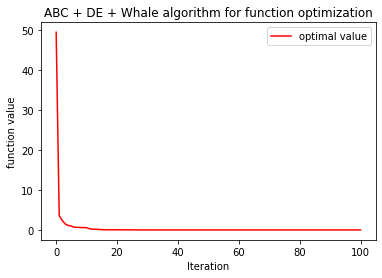

In [17]:
if __name__ == "__main__":
    #random.seed()
    vardim = 5
    bound = np.tile([[-600], [600]], vardim)
    abc_de = ABC_DE_WOA(30, 30, bound, 100, 200)
    #(foodCount, onlookerCount, bound, maxIterCount=1000, maxInvalidCount=200)
    abc_de.solve()